# Triple Barrier Method Application

This notebook develops Exercise 3.1 and 3.3 proposed in AFML

We skip 3.2 as I am not interested in this moment to pay attention to rare labels

- From S&P 500 futures compute dollar bars
- Apply a symmetric CUSUM filter using the standard deviation of daily returns as threshold
- Use a TBM with vertical barries with numDays == 1 and a symmetric multipliers for TP/SL

In [297]:
#general purpose imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

#specific imports
scripts_path = Path("../00_books/AFML/scripts").resolve()
sys.path.append(str(scripts_path))
from AFML_book_scripts import *
from AFML_my_scripts import *

## Get Data and Build Dollar Bars

In [298]:
#import tick data
data = pd.read_csv('../00_books/AFML/data/SP_futures_tick_data.csv')

In [299]:
#manipulate data such that we can transfomr into a dollar bar series
datetime_str = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(datetime_str, errors='coerce')

In [300]:
#only between 2002 and 2012
start_date = '2002-01-01'
end_date = '2012-12-31'
data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]

In [301]:
#get the dollar bar dataframe
dollars_bars_size = 1000000  
df = DollarBarsDfVectorized(data, dollar_per_bar=dollars_bars_size)

## Apply Symmetric CUSUM Filter

In [302]:
# reindex the dataframe to datetime as we will need timeindexed series objects
df = df.drop('start_date', axis=1 )
df = df.rename(columns={'end_date': 'datetime'})
df = df.set_index('datetime')
#drop eventual duplciate indices
df = df[~df.index.duplicated(keep='first')]

In [303]:
#calcualte threshold for CUSUM as std of returns
threshold = df.close.diff().std()

In [304]:
# get CUSUM events using the defined function
CUSUM_events = get_CUSUM_events(gRaw=df.close, h = threshold)
CUSUM_events.shape

(3043,)

## Add Vertical Barrier & Volatility for Target Barriers

In [323]:
numDays = 1
t1=df.close.index.searchsorted(CUSUM_events+pd.Timedelta(days=numDays))
t1=t1[t1<df.close.shape[0]]
t1=pd.Series(df.close.index[t1],index=CUSUM_events[:t1.shape[0]])

In [324]:
target = GetTargetforTBM(df.close, ema_periods=20)

## Set Up TBM

In [307]:
#symmetric pt/sl multipliers
tpsl = (1, 1)
#min return for target as k times the mean of target itself
mean_mulitplier = 1.5
min_return = mean_mulitplier*target.mean()

In [308]:
filtered_events = getEvents(close=df.close, tEvents=CUSUM_events, ptSl = tpsl, 
                            trgt= target, minRet = min_return, t1=t1)

filtered_events

,t1,trgt
2003-07-01 16:25:20.000,2003-07-03 00:13:23.000,0.009836
2003-07-28 00:20:46.000,2003-07-29 02:03:08.000,0.006978
2003-08-05 18:26:48.000,2003-08-07 02:13:25.000,0.007443
2003-08-14 15:49:35.000,2003-08-15 03:49:33.000,0.007121
2004-03-11 15:38:34.000,2004-03-14 17:33:19.000,0.010073
...,...,...
2012-12-20 01:25:19.571,2012-12-20 19:18:57.074,0.007690
2012-12-20 19:18:57.074,2012-12-20 21:42:09.613,0.011031
2012-12-20 21:42:09.613,2012-12-24 01:03:10.532,0.012229
2012-12-26 23:05:29.800,2012-12-28 03:48:55.816,0.010617


In [309]:
labels = getTBMLabels(filtered_events, df.close)

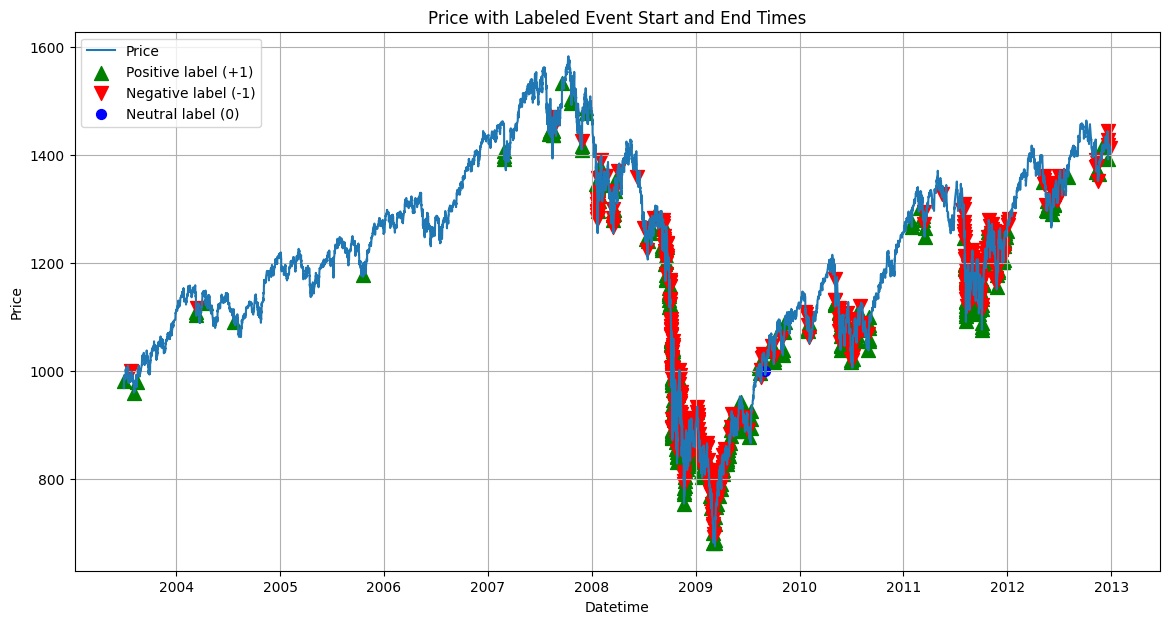

In [310]:
events_labeled = labels
close_plot = df.close

plt.figure(figsize=(14,7))
plt.plot(close_plot.index, close_plot.values, label='Price')

# Filter events by label within the plotting range
pos_events = events_labeled[(events_labeled['bin'] == 1) & (events_labeled.index.isin(close_plot.index))]
neg_events = events_labeled[(events_labeled['bin'] == -1) & (events_labeled.index.isin(close_plot.index))]
neutral_events = events_labeled[(events_labeled['bin'] == 0) & (events_labeled.index.isin(close_plot.index))]

# Plot event markers on price chart
plt.scatter(pos_events.index, close_plot.loc[pos_events.index], color='green', marker='^', label='Positive label (+1)', s=100)
plt.scatter(neg_events.index, close_plot.loc[neg_events.index], color='red', marker='v', label='Negative label (-1)', s=100)
plt.scatter(neutral_events.index, close_plot.loc[neutral_events.index], color='blue', marker='o', label='Neutral label (0)', s=50)


plt.legend()
plt.title('Price with Labeled Event Start and End Times')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.grid(True)
plt.show()


## Modified TBM 

We modify getEvents and getTBMLables to output {-1,0,1} instead of only {-1,1}. That, is we want to know when the vertical barrier is hit.

To do it we...

First modified getEvents --> getEvents_with_hit_type where we just add another column to events whihc will store which barrier has been hit first!

Second...

In [331]:
def getEvents_with_hit_type(close, tEvents, ptSl, trgt, minRet, t1 = False):
    """
    close: pd.Series or prices indexed by datetime
    tEvents: timeindex with timestamps of events selected by a sampling procedure (ex CUSUM)
    ptSl: tuple (tp, sl) take profit e stop loss multipliers (for eventual asymetr)c positioning)
    trgt: pd.Series of targets expresses in term of abs returns (e.g. 0.02 for 2% target)
    minRet: min target return to consider an event
    t1: pd.Series optional for vertical barriers (max holding period), default False (no limit)
    
    retunrs...

    df with:
    - t1: timestamp at which the first barrier is hit (either tp, sl or vertical barrier)
    - trgt: target return for the event used to generate the barriers 
    
    Note:
    - to increase th enumebr of t1 = veticla barriers we need to increaet he multipliets tpsl
    - increasing minret will only filter out more events
    """

    # filter for only tEvents and consider only those above minRet
    trgt_subset = trgt.loc[tEvents]
    trgt_subset = trgt_subset[trgt_subset > minRet]

    #get the vertical barrier
    if t1 is False:
        t1= pd.Series(pd.NaT, index=trgt_subset.index)

    #set side (here always long = 1)
    side_ = pd.Series(1., index=trgt_subset.index)

    # events dataframe
    events = pd.concat({'t1': t1, 'trgt': trgt_subset, 'side': side_}, axis=1).dropna(subset=['trgt'])

    # applyTPSLOnT1 (no multiprocessing)
    df0 = applyTPSLOnT1(close=close, events=events, tpsl=ptSl, molecule=events.index)

####### MOD #######
    first_hits = df0.dropna(how='all').idxmin(axis=1)  # returns 'tp', 'sl', or 't1'
    events['hit_first'] = first_hits.map({'tp': 'tp', 'sl': 'sl', 't1': 'vb'})
#####################

    #update t1 wiuth the first event occurring between tp and sl and t1
    events['t1'] = df0.dropna(how='all').min(axis=1)
    
    # remove side column
    events = events.drop('side', axis=1)

    return events

In [332]:
filtered_events = getEvents_with_hit_type(close=df.close, tEvents=CUSUM_events, ptSl = tpsl, 
                            trgt= target, minRet = min_return, t1=t1)

filtered_events

,t1,trgt,hit_first
2003-07-01 16:25:20.000,2003-07-03 00:13:23.000,0.009836,vb
2003-07-28 00:20:46.000,2003-07-29 02:03:08.000,0.006978,vb
2003-08-05 18:26:48.000,2003-08-07 02:13:25.000,0.007443,vb
2003-08-14 15:49:35.000,2003-08-15 03:49:33.000,0.007121,tp
2004-03-11 15:38:34.000,2004-03-14 17:33:19.000,0.010073,vb
...,...,...,...
2012-12-20 01:25:19.571,2012-12-20 19:18:57.074,0.007690,sl
2012-12-20 19:18:57.074,2012-12-20 21:42:09.613,0.011031,tp
2012-12-20 21:42:09.613,2012-12-24 01:03:10.532,0.012229,vb
2012-12-26 23:05:29.800,2012-12-28 03:48:55.816,0.010617,vb


Second... we modify getTBMLabels --> getTBMLables_withVB

In [334]:
def getTBMLabels_withVB(events, close):
    # 1) Align prices with event start and end times (t1)
    events_ = events.dropna(subset=['t1'])  # keep events that have an end time
    px = events_.index.union(events_['t1'].values).drop_duplicates()  # union of start and end times
    px = close.reindex(px, method='bfill')  # get prices at these times, backfill missing

    # 2) Create output DataFrame indexed by event start times
    out = pd.DataFrame(index=events_.index)

    # Calculate return between event start and end time
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1

    # Assign bins based on return sign (+1, 0, -1)
    out['bin'] = np.sign(out['ret'])

    # Override with 0 when vertical barrier was first hit
    out.loc[events_['hit_first'] == 'vb', 'bin'] = 0

    out['t1'] = events_['t1']  # include event end time

    return out


In [336]:
labels_with_vb = getTBMLabels_withVB(filtered_events, df.close)
labels_with_vb

,ret,bin,t1
2003-07-01 16:25:20.000,0.010079,0.0,2003-07-03 00:13:23.000
2003-07-28 00:20:46.000,-0.004504,0.0,2003-07-29 02:03:08.000
2003-08-05 18:26:48.000,0.005938,0.0,2003-08-07 02:13:25.000
2003-08-14 15:49:35.000,0.011429,1.0,2003-08-15 03:49:33.000
2004-03-11 15:38:34.000,0.011050,0.0,2004-03-14 17:33:19.000
...,...,...,...
2012-12-19 05:10:15.160,-0.010802,-1.0,2012-12-20 01:25:19.571
2012-12-20 01:25:19.571,-0.025619,-1.0,2012-12-20 19:18:57.074
2012-12-20 19:18:57.074,0.019109,1.0,2012-12-20 21:42:09.613
2012-12-20 21:42:09.613,-0.000423,0.0,2012-12-24 01:03:10.532


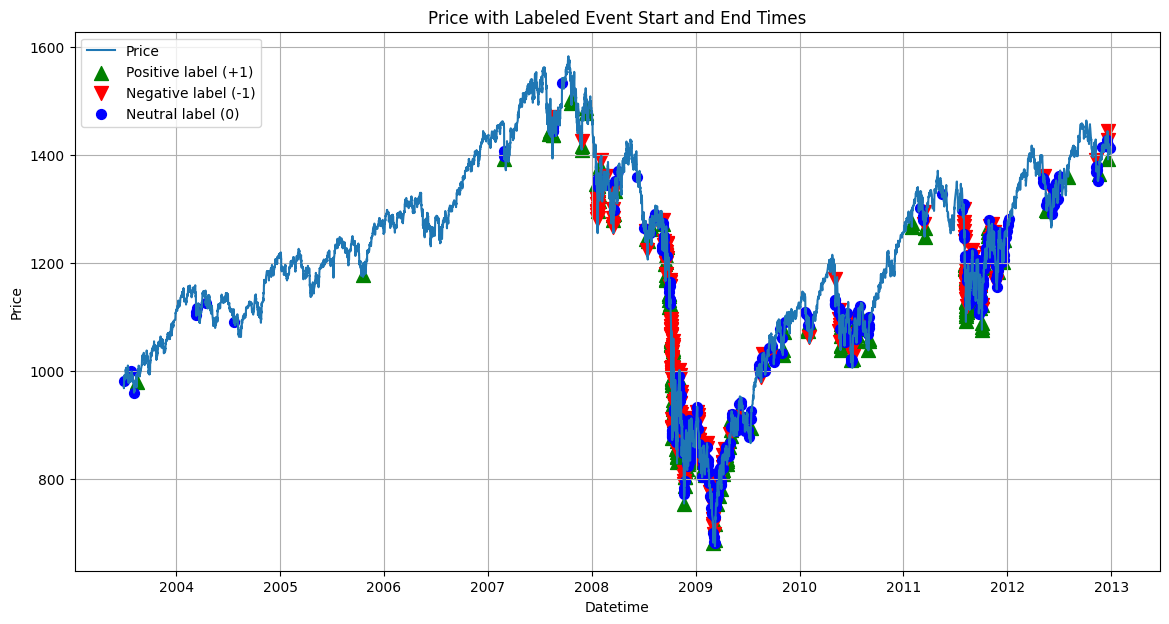

In [337]:
events_labeled = labels_with_vb
close_plot = df.close

plt.figure(figsize=(14,7))
plt.plot(close_plot.index, close_plot.values, label='Price')

# Filter events by label within the plotting range
pos_events = events_labeled[(events_labeled['bin'] == 1) & (events_labeled.index.isin(close_plot.index))]
neg_events = events_labeled[(events_labeled['bin'] == -1) & (events_labeled.index.isin(close_plot.index))]
neutral_events = events_labeled[(events_labeled['bin'] == 0) & (events_labeled.index.isin(close_plot.index))]

# Plot event markers on price chart
plt.scatter(pos_events.index, close_plot.loc[pos_events.index], color='green', marker='^', label='Positive label (+1)', s=100)
plt.scatter(neg_events.index, close_plot.loc[neg_events.index], color='red', marker='v', label='Negative label (-1)', s=100)
plt.scatter(neutral_events.index, close_plot.loc[neutral_events.index], color='blue', marker='o', label='Neutral label (0)', s=50)


plt.legend()
plt.title('Price with Labeled Event Start and End Times')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.grid(True)
plt.show()
